# Fruit Classification Using MobileNetV2

## Data Loading

In [1]:
!kaggle datasets download -d karimabdulnabi/fruit-classification10-class

Dataset URL: https://www.kaggle.com/datasets/karimabdulnabi/fruit-classification10-class
License(s): CC0-1.0
 89% 26.0M/29.2M [00:01<00:00, 33.8MB/s]
100% 29.2M/29.2M [00:01<00:00, 21.9MB/s]


In [2]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fruit-classification10-class.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

## Data Preparation

In [3]:
# Improting Necessory Libraries

import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import InceptionV3
from keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Flatten,GlobalAveragePooling2D, Dropout

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Data Augmentation

train_datagen = ImageDataGenerator(rescale = 1./255,
                             rotation_range=40,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             validation_split=0.2)

val_datagen = ImageDataGenerator(rescale = 1./255,
                                validation_split=0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_df = train_datagen.flow_from_directory(
    directory = '/content/MY_data/train',
    batch_size = 32,
    target_size = (224, 224),
    class_mode='categorical',
    subset="training",
    seed=123
)

validation_df = val_datagen.flow_from_directory(
    directory='/content/MY_data/train',
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
    subset="validation",
    seed=123
)


test_df = train_datagen.flow_from_directory(
    directory = '/content/MY_data/test',
    batch_size = 32,
    target_size = (224, 224),
    class_mode='categorical'
)

Found 1841 images belonging to 10 classes.
Found 460 images belonging to 10 classes.
Found 1025 images belonging to 10 classes.


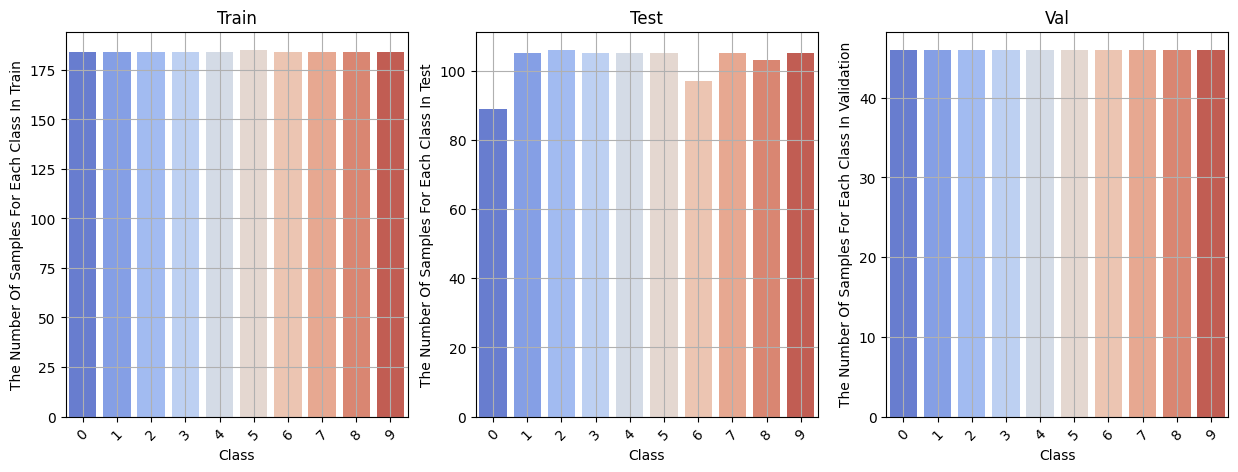

In [6]:
# Checking if the data is imbalance or not

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
labels = [train_df.class_indices[os.path.basename(os.path.dirname(file_path))] for file_path in train_df.filenames]
ax = sns.countplot(x=labels, palette='coolwarm')
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Train")
plt.title('Train')
plt.grid(True)
plt.xticks(rotation=45)

plt.subplot(1,3,2)
labels = [test_df.class_indices[os.path.basename(os.path.dirname(file_path))] for file_path in test_df.filenames]
ax = sns.countplot(x=labels, palette='coolwarm')
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Test")
plt.title('Test')
plt.grid(True)
plt.xticks(rotation=45)

plt.subplot(1,3,3)
labels = [validation_df.class_indices[os.path.basename(os.path.dirname(file_path))] for file_path in validation_df.filenames]
ax = sns.countplot(x=labels, palette='coolwarm')
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Validation")
plt.title('Val')
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

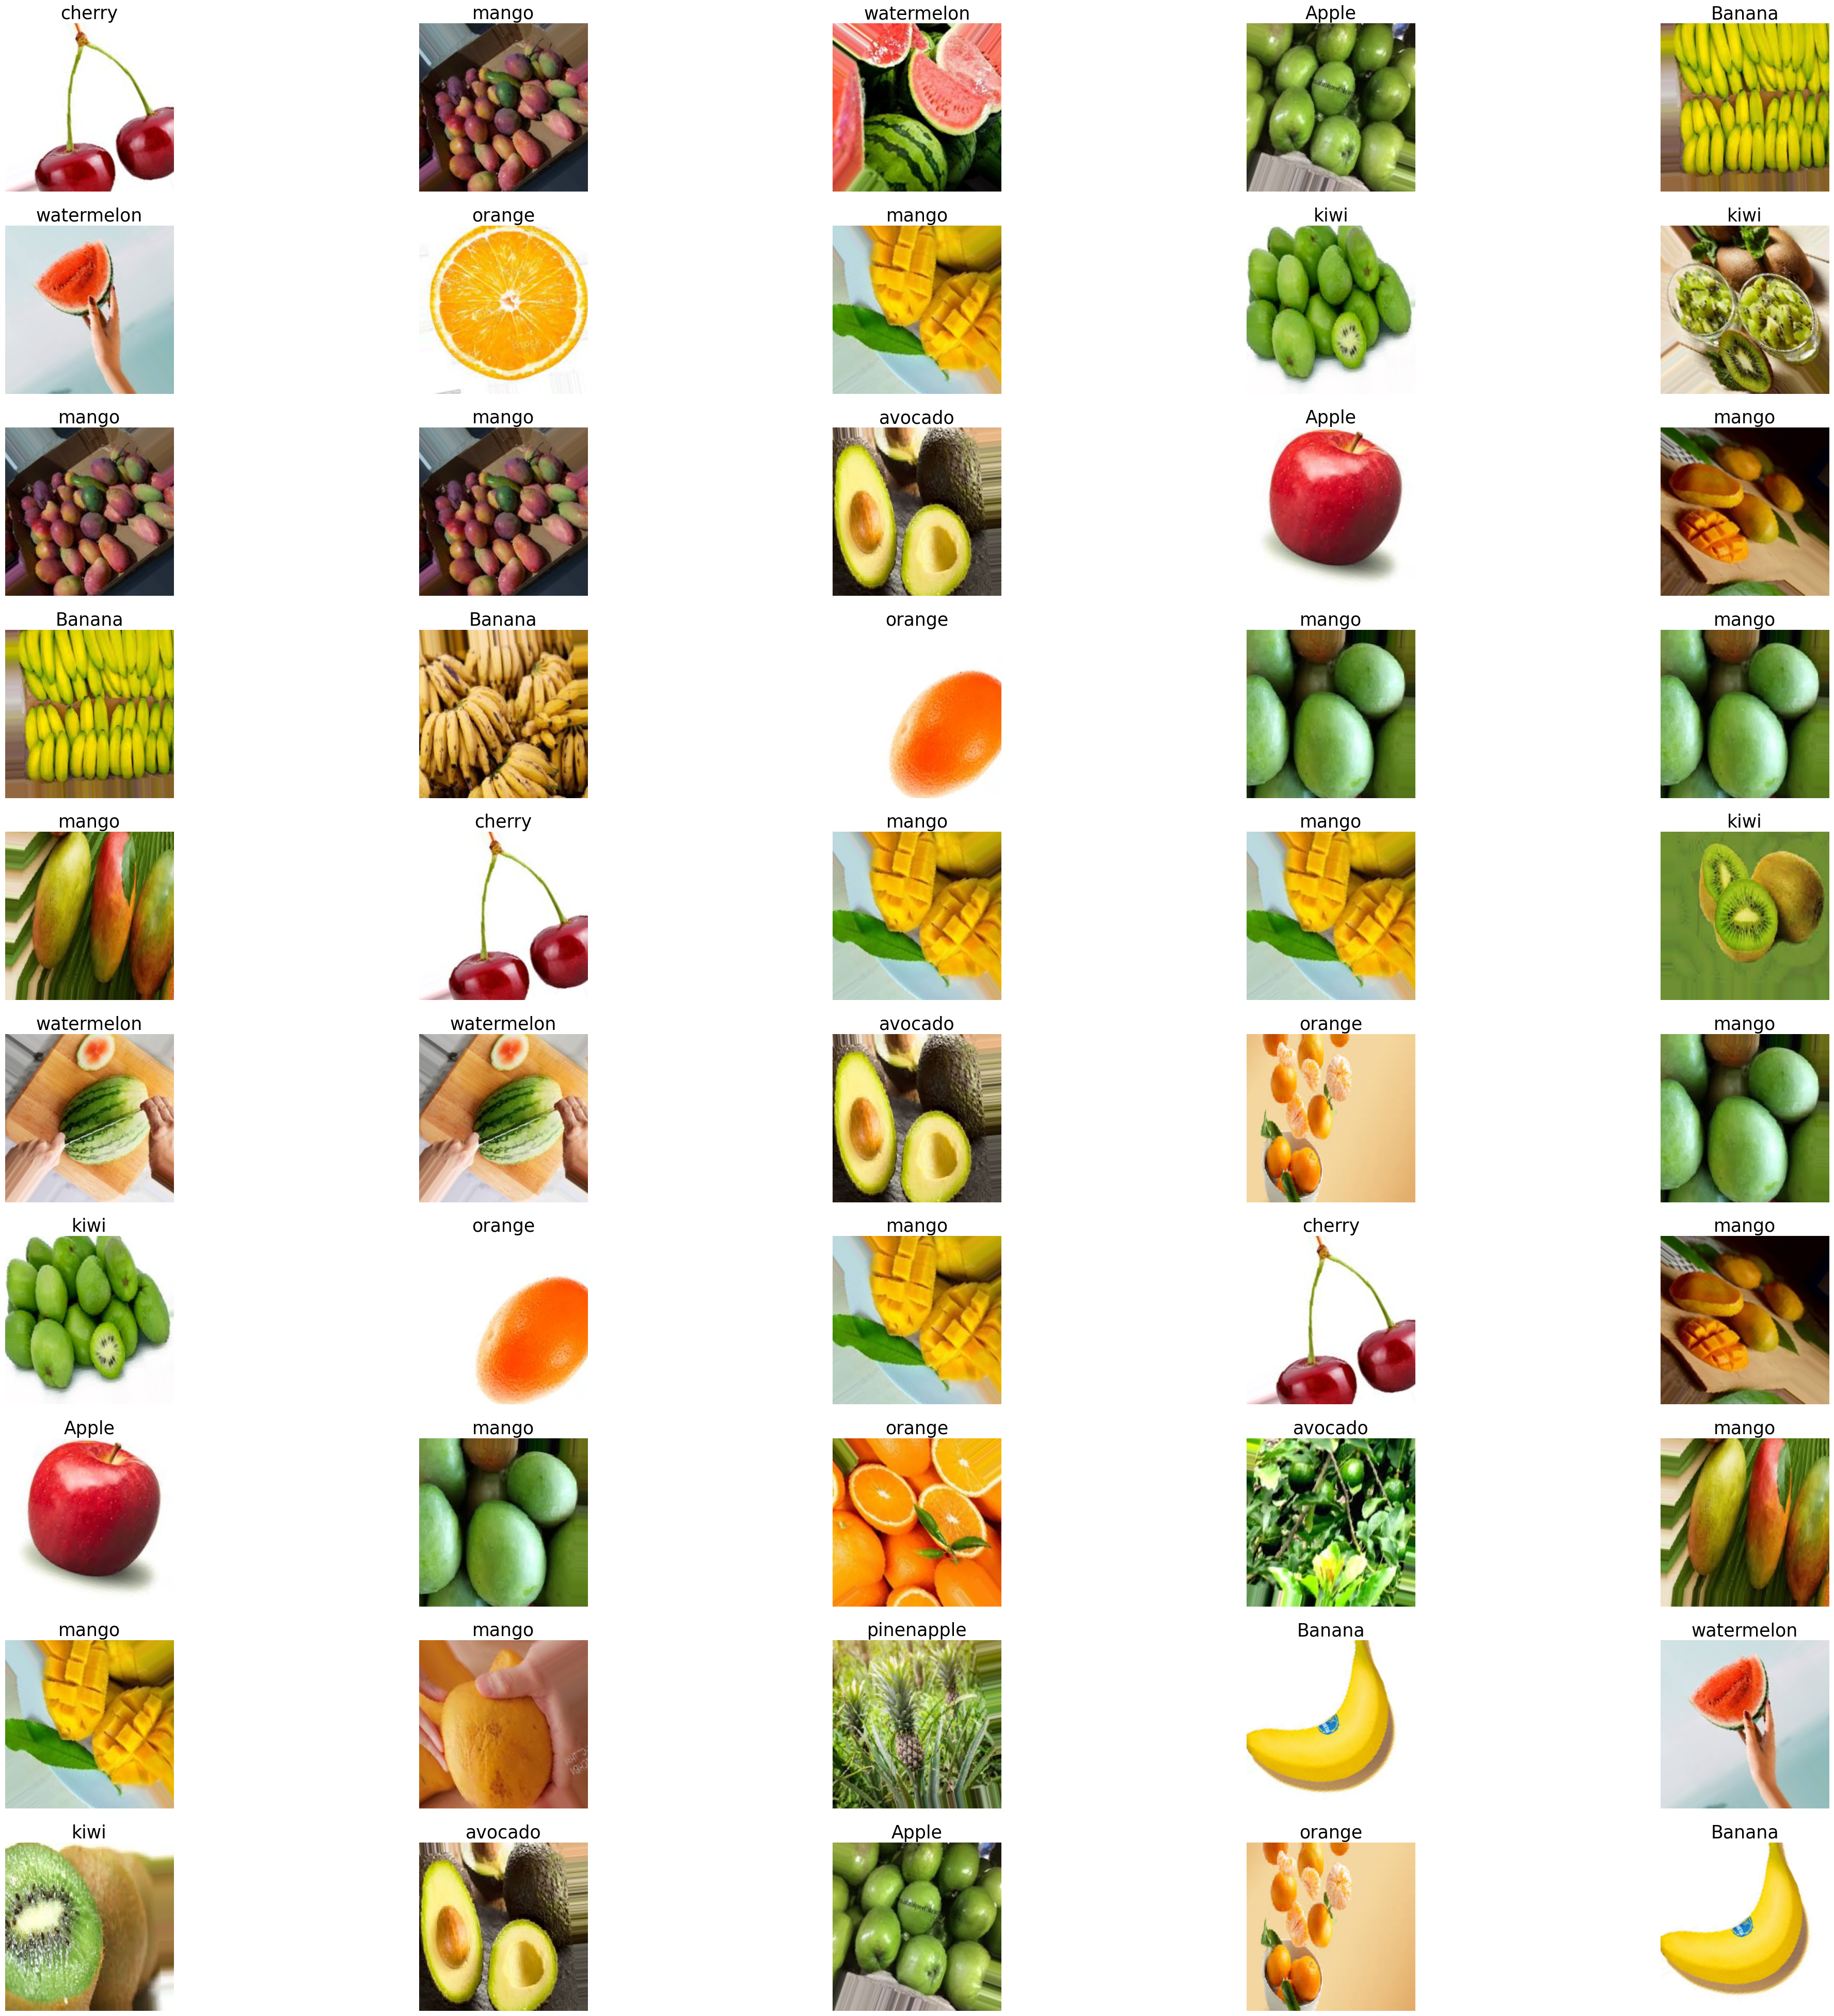

In [8]:
# Visualizing the Dataset

plt.figure(figsize=(50,50))

images, labels = next(train_df)

for n, i in enumerate(np.random.randint(0, len(images), 50)):
    plt.subplot(10, 5, n + 1)
    plt.imshow(images[i])
    plt.axis('off')

    label_index = np.argmax(labels[i])
    class_name = list(train_df.class_indices.keys())[list(train_df.class_indices.values()).index(label_index)]
    plt.title(class_name, fontsize=25)

plt.show()

## Model Building

In [9]:
MobileNetV2_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3),
                              pooling='avg')

MobileNetV2_base.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
model = Sequential([

    MobileNetV2_base,
    BatchNormalization(),
    Dropout(0.35),
    Dense(220, activation='relu'),
    Dense(60, activation='relu'),
    Dense(10, activation='softmax')

])

In [11]:
base_learning_rate = 0.0001

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
history= model.fit(
    train_df,
    validation_data=validation_df,
    steps_per_epoch=len(train_df),
    epochs=80
)

Epoch 1/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 621ms/step - accuracy: 0.1353 - loss: 2.5565 - val_accuracy: 0.5543 - val_loss: 1.7255
Epoch 2/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 24s 419ms/step - accuracy: 0.4816 - loss: 1.5704 - val_accuracy: 0.7826 - val_loss: 1.1740
Epoch 3/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 25s 413ms/step - accuracy: 0.6731 - loss: 1.1276 - val_accuracy: 0.8435 - val_loss: 0.8086
Epoch 4/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 25s 430ms/step - accuracy: 0.7658 - loss: 0.8106 - val_accuracy: 0.8804 - val_loss: 0.5941
Epoch 5/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 41s 423ms/step - accuracy: 0.8006 - loss: 0.6956 - val_accuracy: 0.8913 - val_loss: 0.4784
Epoch 6/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 40s 403ms/step - accuracy: 0.8402 - loss: 0.5437 - val_accuracy: 0.8913 - val_loss: 0.4092
Epoch 7/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 25s 430ms/step - accuracy: 0.8421 - loss: 0.5285 - val_accuracy: 0.9022 - val_loss: 0.3639
Epoch 8/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 25s 424ms/step - accuracy: 0.8770 - loss: 0.4284 - val_accu

## Model Evaluation

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9175 - loss: 0.2600


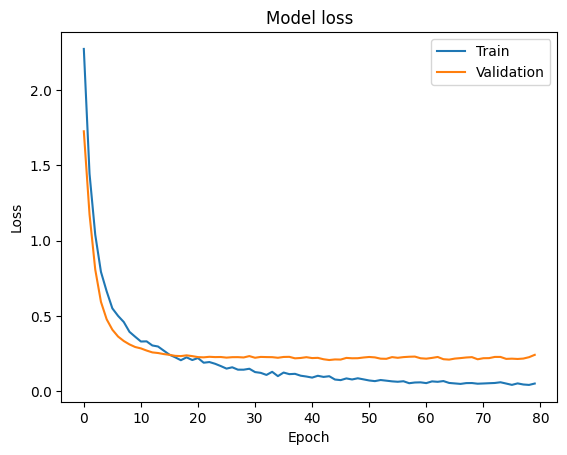

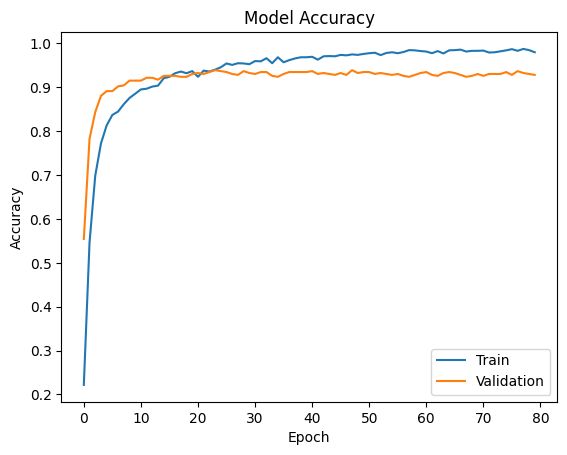

In [13]:
loss = model.evaluate(validation_df)

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()